In [1]:
import os
import cv2
import mrcnn.config
import mrcnn.visualize
import mrcnn.utils
from mrcnn.model import MaskRCNN
from pathlib import Path


# Configuration that will be used by the Mask-RCNN library
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes + one background class


# Root directory of the project
ROOT_DIR = os.path.abspath("../shot_type_classfication_resnet50")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")


# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# Create a Mask-RCNN model in inference mode
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())

# Load pre-trained model
model.load_weights(COCO_MODEL_PATH, by_name=True)

# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Load the image we want to run detection on




Using TensorFlow backend.


In [16]:
"""
Mask R-CNN
Display and Visualization Functions.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import sys
import logging
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils


############################################################
#  Visualization
############################################################

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interporlation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,image[:, :, c] *(1 - alpha) + alpha * color[c] * 255,image[:, :, c])
    return image


#image[:, :, c] = np.where(mask == 1,color[c] * 255,image[:, :, c])
def display_instances(image, boxes, masks, class_ids, class_names, #semantic segmentation
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """ 
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Mask
        mask = masks[:, :, i]
        print(mask)
        if show_mask:
            masked_image = apply_mask(masked_image, mask, [0,0,1])

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=[0,0,1])
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    print(masked_image.astype(np.uint8))
    R,G,B = cv2.split(masked_image.astype(np.uint8))
    image = cv2.merge([B,G,R])

    return image
    #if auto_show:
    #    plt.show()

In [17]:
def display_instances2(image, boxes, masks, class_ids, class_names, ## 박스만 치기
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            image = cv2.rectangle(image, (x1, y1), (x2,y2), (0,0,255), 3)
    R,G,B = cv2.split(image)
    image = cv2.merge([B,G,R]) 
    return image


In [14]:
def display_instances3(image, boxes, masks, class_ids, class_names, #semantic segmentation
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """ 
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Mask
        mask = masks[:, :, i]
        #if show_mask:
        #    masked_image = apply_mask(masked_image, mask, [0,0,1])

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.1)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=[0,0,1])
            ax.add_patch(p)
            print(p)
    ax.imshow(masked_image.astype(np.uint8))
    R,G,B = cv2.split(masked_image.astype(np.uint8))
    image = cv2.merge([B,G,R])

    return image
    #if auto_show:
    #    plt.show()

Processing 1 images
image                    shape: (720, 1280, 3)        min:    8.00000  max:  149.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   24.30000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[[13 13 13]
  [13 13 13]
  [13 13 13]
  ...
  [13 13 13]
  [13 13 13]
  [13 13 13]]

 [[13 13 13]
  [13 13 13]
  [13 13 13]
  ...
  [13 13 13]
  [13 13 13]
  [13 13 13]]

 [[13 13 13]
  [13 13 13]
  [13 13 13]
  ...
  [13 13 13]
  [13 13 13]
  [13 13 13]]

 ...

 [[13 13 13]
  [13 13 13]
  [13 13 13]
  ...
  [13 13 13]
  [13 13 13]

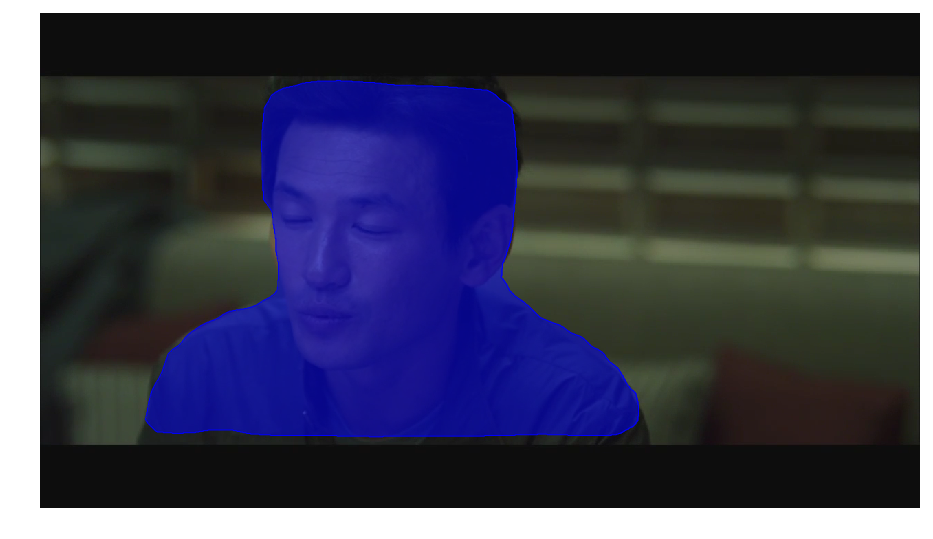

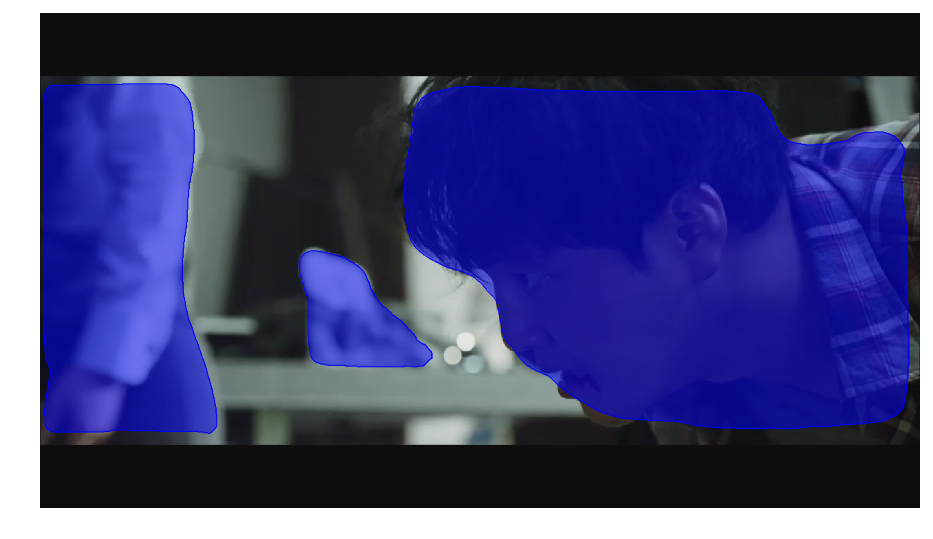

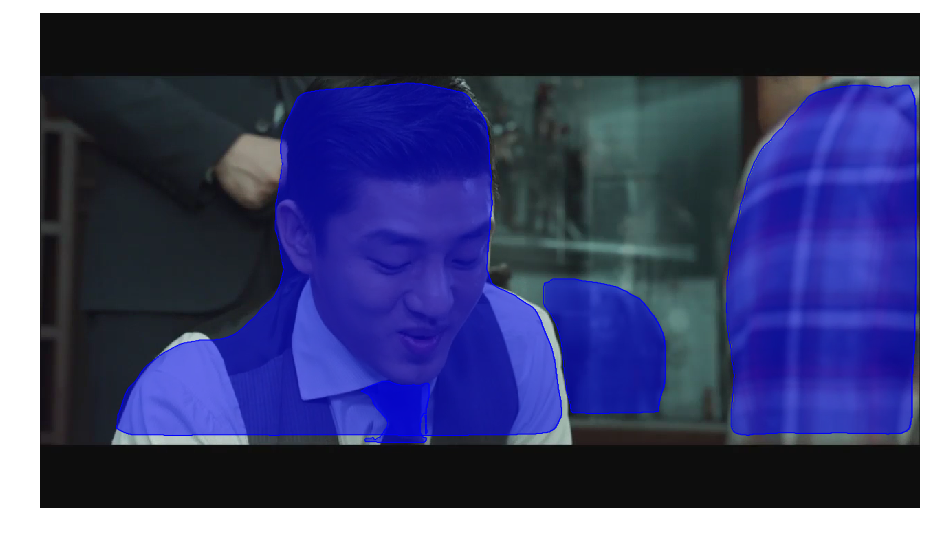

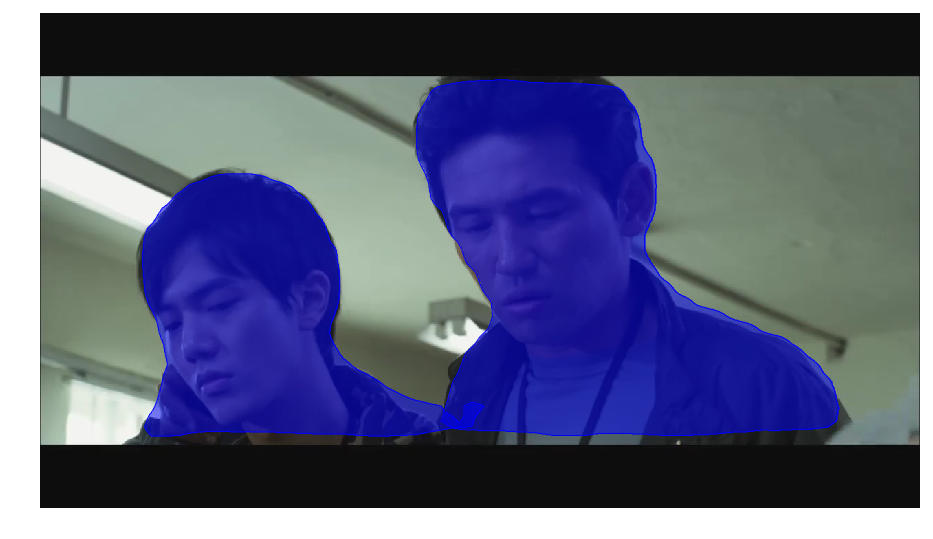

In [18]:
import cv2
import numpy as np
import glob
import os

images = [cv2.imread(file,cv2.IMREAD_COLOR) for file in glob.glob("tt/*.png")]

mrcnn_path = 'ttt'


# Iterate through each image, perform edge detection, and save image
number = 0
for image in images:
    
    B,G,R = cv2.split(image)
    image = cv2.merge([R,G,B])
    results = model.detect([image], verbose=1)
# Visualize results
    r = results[0]
    image = display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    
    cv2.imwrite(os.path.join(mrcnn_path , 'train_close_up{}.png'.format(number)),image)
    number += 1